# Survival analysis of leukemia data with GPs.

This is a demo for survival analysis using GPy library written in Python notebook.
We will show how covariates like age or WBC count affect mortality in leukemia patients.
The mortality is expressed by the amount of time(in days) the person is expected to live.
This demo is available in [2] in MATLAB. You can read more about Survival Analysis from [4]. 
This demo was also presented in [1].

Please note, some of the functionality like log-logistic likelihood and the EP implementation is not available in GPy yet,and has been added but there might be some chance of bug in the implementation or some corner-cases where it might not work so well.



In [1]:
import numpy as np
import scipy
import matplotlib
# from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import pickle

Load GPy library here ... 

In [2]:
import GPy
from GPy.plotting.matplot_dep.util import fixed_inputs

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Math, Latex

Pandas is a nice library for loading data and data munging, which we use here.

In [4]:
import pandas as pd
from scipy.stats import gmean

In [35]:
from scipy.cluster.vq import kmeans as sp_kmeans

In [5]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

In [6]:
from IPython.display import display

In [7]:
# set all the flags here ...
NORMALISE = True

simple functions to normalise the data, although this is not really needed with GPY, as it does it internally too.. 

The normalisation is expressed by : $$ \hat{X} = \frac{X - \mu_{X}}{\sigma_{X}} $$

In [8]:
# x should be a vector
MEAN = np.zeros((1,3))
STD = np.zeros((1,3))
def normalise(x):
    n_rows, n_cols = x.shape
    MEAN, STD = np.nanmean(x, axis=0), np.nanstd(x,axis=0)
    x_norm = (x - MEAN) / STD
    return x_norm


def unnormalise(x, mean, std):
    x_unnorm = x*std + mean
    return x_unnorm
    

Load the file in pandas as a dataframe, and then take the numeric part.

In [9]:
filename = 'leukemia.txt'
le_df = pd.read_table(filename, sep=' ', header=None, names=['time', 'cens', 'xcoord', 'ycoord', 'age', 'sex', 'wbc', 'tpi', 'district'])
le_np = le_df.as_matrix()

Check if the data looks ok 

In [10]:
le_df[100:105]

,time,cens,xcoord,ycoord,age,sex,wbc,tpi,district
100,6,1,0.181918,0.826902,70,1,0.0,-4.56,7
101,7,1,0.254686,0.522602,54,-1,101.0,-5.20,9
102,7,1,0.544653,0.533627,87,-1,182.0,-3.98,3
103,7,1,0.127894,0.517089,76,1,5.4,-0.77,5
104,7,1,0.294377,0.229327,88,-1,12.6,1.73,24


Save the data in a pickled file, and save it to the current working directory.

Take the survival time from the data and save it as y(outcome variable)




In [11]:
# survival_time 
y_st = le_df['time']

In [12]:
y_gmean = gmean(y_st)
Y = y_st / y_gmean
Y = Y[:,None]
print(y_gmean)

134.979340646


## Output Normalisation

Normalise output variable Y by dividing it by its geometric mean.
Another way to normalise is by taking the log of the survival times. 1 is added to Y to avoid any zero-errors.

$$ \bar{Y} = \frac{Y}{\hat{Y}}   \quad  \hat{Y} = \prod_{i=1}^{n=N}y_{i} $$
$$ \bar{Y} = \log(Y+1) $$

 Another way to load the dataset is by using the pods subpackage as shown below.
 This will require you to download the dataset, just uncomment the below code and execute the code.

In [13]:
# import pods
# leukemia = pods.datasets.leukemia()
# X = leukemia['X'].copy()
# Y = leukemia['Y'].copy()
# Y = Y / gmean(Y)
# Y = Y.reshape(-1,1)

## Censoring

An important part of survival data is the censoring information, the censoring variable tells us if the data is censored or not. In our example, we only consider right-censoring. Right-censoring means that the event(death in this case) did not occur before the study period ended. Censoring = 1 (when the data is censored) and 0 when it is not. However, some people record this information in the otherway, as in this case, so we subtract the variable from 1, to get the desired format for our analysis.

In [14]:
Z_t = le_df.as_matrix(['cens'])
Z = Z_t.copy()
Z = 1 - np.asarray(Z)
Z = np.asarray(Z)
Y_metadata = dict()
Y_metadata['censored'] = Z

Make the sex covariate positive as GPy handles that better 0 - females and 1 for males 

In [42]:
def kmeans(Xtrain, k, seed):
    Z, _ = sp_kmeans(Xtrain, k)
    return Z

## WBC count normalisation
The wbc count values can vary a lot, so we take the log of WBC count, and add a small positive value to it to avoid taking log of 0. Normalise all the covariates except the sex value as it is discrete.

In [15]:

df_covar = le_df.as_matrix(['age', 'sex', 'wbc', 'tpi'])
X = df_covar.copy()
n_rows, n_cols = X.shape
X[:,2] = np.log10(X[:,2] + 0.50)
XS = X[:,[0,2,3]]

if NORMALISE:
    xtemp = normalise(XS)
XF = X.copy()
XF[:,0] = xtemp[:,0]
XF[:,2] = xtemp[:,1]
XF[:,3] = xtemp[:,2]
# 0-1 case is better ...
# 0:females,1:males
XF[:,1] = (X[:,1] + 1) / 2.

Take a small subset of the data- which can be used later for testing and doing cross-validation and check the dimensions are ok for our data.

In [16]:
X_test = X[np.random.randint(X.shape[0], size=200),:]
# print(XF.shape)
XF_DF = pd.DataFrame(data=XF)

In [17]:
X_mean, X_std = np.nanmean(X, axis=0), np.nanstd(X, axis=0)

In [18]:
X1 = XF[:,0]
X2 = XF[:,2]
X3 = XF[:,3]

## Likelihoods
In this example, we will try out with different likelihoods - weibull, Loggaussian and Loglogistic. Loglogistic generally does better than the other two, we can compare the marginal likelihood of the models later.

Weibull likelihood:
$$ p(y|f,r) = \prod_{i=1}^{n} [ r^{1-z_{i}}\exp(-(1-z_{i})f(x_{i}))y_{i}^{(1-z_{i})(r-1)}\exp(-y_{i}^{r}/\exp(f(x_{i}))) ] $$
where y is the output, z is the censoring variable, and r is the shape parameter.

The loglogistic likelihood is given below:
$$ L = \prod_{i=1}^{n} (\frac{ry^{r-1}}{\exp{f(x_{i})}})^{1-z_i} (1 + (\frac{y}{\exp(f(x_{i}))})^{r})^{z_i-2}  $$

where r is the shape parameter.

The loggaussian likelihood is given below:
$$ L = \prod_{i=1}^{n}(2\pi\sigma^2)^{-(1-z_{i})/2} y_{i}^{1-z_{i}}\exp(-\frac{(1-z_{i})(log(y_{i}) - f(x_{i}))^{2}}{2\sigma^{2}})( 1 - \Phi(log( \frac{y_{i}-f(x_{i}} {\sigma})))^{z_i} $$

All the likelihoods given above share one property: the y values can only be positive. 

In [19]:
# like_loggaussian = GPy.likelihoods.LogGaussian()
like_loglogistic = GPy.likelihoods.LogLogistic()
like_weibull = GPy.likelihoods.Weibull()
like_loglogistic2 = GPy.likelihoods.LogLogistic(r=0.94)

In [20]:
print like_loglogistic

  LogLogistic.  |  value  |  constraints  |  priors
  r_log_shape   |    1.0  |      +ve      |        


## Inference
The likelihoods described above are not gaussian, so the inference cannot be exact, hence we have to use an approximation. There are two different inference schemes available: Laplace and EP(Expectation Propagation), EP is not yet implemented for these likelihoods, so we use Laplace inference here. The laplace inference works by placing a gaussian distribution approximation over the mode of the non gaussian posterior. The Taylor expansion can be used to write the posterior function as a series of sum of the higher order derivatives of the posterior at the mode. 


In [21]:
# set function for approximate inference - Laplacian or EP.
laplacian_inf = GPy.inference.latent_function_inference.Laplace()
n_dims = XF.shape[1]
print n_dims

4


In [22]:
ep_inf = GPy.inference.latent_function_inference.EP()

## Kernel
We use a rbf(exponentiated quadratic) kernel. We can use the additive property of the GPs. Sum of two GPs is also a GP. So we can combine multiple GPs by summing them. The Bias kernel helps us to model the constant function part of the latent process, white kernel is used to model the white noise and ebf kernel models the variability of the process wrt x. We also use ARD as true, this parameter helps us to model the GP over different dimensions of the input variable X, and the length scale hyperparameter is different for each dimension.
### Squared Exponential Kernel: ###
$$ k_{SE}(x, x') = \sigma_{2}\exp(- \frac{(x-x')^2}{2l^{2}}) $$ 
### Linear Kernel ###
$$ k_{Lin}(x, x') = \sigma_{b}^{2} + \sigma_{v}^{2}(x-c)(x'-c) $$

Linear Kernel is a bit special because it is non-stationary and imparts linear properties to the shape of the underlying function f. If used alone, a GP with linear kernel will simply be Bayesian Linear Regression.


In [23]:
kern_RBF1 = GPy.kern.RBF(input_dim=XF.shape[1], variance=1., lengthscale=1., ARD=1)
kern_Constant = GPy.kern.Bias(input_dim=XF.shape[1], variance=1.)
kern_White = GPy.kern.White(input_dim=XF.shape[1], variance=1.)
kern_Linear = GPy.kern.Linear(input_dim=XF.shape[1], ARD=1)
kernel1 = kern_RBF1 + kern_Constant + kern_White
kernelleu = kernel1 + kern_Linear

In [24]:
print XF[:2]

[[ 0.01496327  0.          0.22095347 -0.63225161]
 [ 0.83349576  0.          2.12583772 -1.02538818]]


## Prior Specification for Hyperparameters(Hyperpriors)
We will set constraints and priors for the hyperparameters here in this section. Some constraints are obvious: for example length-scale and variances cannot be negative, and so we can place a Gamma/Student-T prior on them. We can also check how the distribution looks like by plotting functionality.

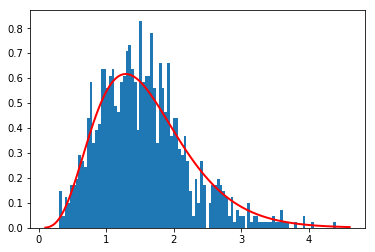

In [25]:
gamma_prior = GPy.priors.Gamma.from_EV(1.6, 0.5)
# invchisquared_prior = GPy.priors.ScaledInvChisquared(0,1,1)
gamma_prior.plot()
# invchisquared_prior.plot()

## Model Specification
Now we have all the components to build a model. We create multiple models using different likelihoods or different kernel functions. We can compare these models by their respective marginal likelihoods or LOO-CV(Leave one out cross validation) score. We can specify different likelihoods, different hyperpriors, different kernel functions and even compare their performance with their marginal objective.

In [26]:
m1 = GPy.core.GP(XF, Y.copy(), kernel=kernelleu.copy(), likelihood=like_loglogistic.copy(), inference_method=laplacian_inf, name='survival1', Y_metadata=Y_metadata)
# m1.rbf.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
# m1.kern.lengthscale.set_prior(GPy.priors.StudentT(mu=0, nu=1, sigma=1.))

In [27]:
m2 = GPy.core.GP(XF, Y.copy(), kernel=kernelleu.copy(), likelihood=like_weibull.copy(), inference_method=laplacian_inf, name='survival3', Y_metadata=Y_metadata)

In [28]:
# m3 = GPy.core.GP(XF, Y.copy(), kernel=kernelleu.copy(), likelihood=like_loggaussian.copy(), inference_method=laplacian_inf, name='survival4', Y_metadata=Y_metadata)

In [29]:
m4 = GPy.core.GP(XF, Y.copy(), kernel=kernelleu.copy(), likelihood=like_loglogistic2.copy(), inference_method=laplacian_inf, name='survival1', Y_metadata=Y_metadata)
# m1.rbf.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
# m1.kern.lengthscale.set_prior(GPy.priors.StudentT(mu=0, nu=1, sigma=1.))

## Check model properties
We can check the model by using the following commands.

In [30]:
display(m1)
print(m1[''])

survival1.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,"(4,)",+ve,
sum.bias.variance,1.0,+ve,
sum.white.variance,1.0,+ve,
sum.linear.variances,"(4,)",+ve,
LogLogistic.r_log_shape,1.0,+ve,


  index  |         survival1.sum.rbf.variance  |  constraints  |  priors
  [0]    |                         1.00000000  |      +ve      |        
  -----  |      survival1.sum.rbf.lengthscale  |  -----------  |  ------
  [0]    |                         1.00000000  |      +ve      |        
  [1]    |                         1.00000000  |      +ve      |        
  [2]    |                         1.00000000  |      +ve      |        
  [3]    |                         1.00000000  |      +ve      |        
  -----  |        survival1.sum.bias.variance  |  -----------  |  ------
  [0]    |                         1.00000000  |      +ve      |        
  -----  |       survival1.sum.white.variance  |  -----------  |  ------
  [0]    |                         1.00000000  |      +ve      |        
  -----  |     survival1.sum.linear.variances  |  -----------  |  ------
  [0]    |                         1.00000000  |      +ve      |        
  [1]    |                         1.00000000  |   

In [31]:
display(m2)
print(m2[''])

survival3.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,"(4,)",+ve,
sum.bias.variance,1.0,+ve,
sum.white.variance,1.0,+ve,
sum.linear.variances,"(4,)",+ve,
Weibull.r_weibull_shape,1.0,+ve,


  index  |         survival3.sum.rbf.variance  |  constraints  |  priors
  [0]    |                         1.00000000  |      +ve      |        
  -----  |      survival3.sum.rbf.lengthscale  |  -----------  |  ------
  [0]    |                         1.00000000  |      +ve      |        
  [1]    |                         1.00000000  |      +ve      |        
  [2]    |                         1.00000000  |      +ve      |        
  [3]    |                         1.00000000  |      +ve      |        
  -----  |        survival3.sum.bias.variance  |  -----------  |  ------
  [0]    |                         1.00000000  |      +ve      |        
  -----  |       survival3.sum.white.variance  |  -----------  |  ------
  [0]    |                         1.00000000  |      +ve      |        
  -----  |     survival3.sum.linear.variances  |  -----------  |  ------
  [0]    |                         1.00000000  |      +ve      |        
  [1]    |                         1.00000000  |   

## Model Optimisation
Below, we optimize the models by using some standard non convex optimizer like BFGS or Newton-CG.

In [32]:
model_list = [ m1, m2]

Check if the models are ok with the "checkgrad()" function .

In [33]:
m1.checkgrad()

True

In [34]:
m1.constrain_positive('')
m1['.*white'].constrain_bounded(1e-6,1e-2)
m1['.*bias'].constrain_bounded(1e-3,3)
m1.optimize('bfgs', max_iters=600)
print(m1)
print(m1.log_likelihood())
print(m1[''])


Name : survival1
Objective : 1636.16832868
Number of Parameters : 12
Number of Optimization Parameters : 12
Updates : True
Parameters:
  survival1.               |              value  |  constraints  |  priors
  sum.rbf.variance         |     0.663433650571  |      +ve      |        
  sum.rbf.lengthscale      |               (4,)  |      +ve      |        
  sum.bias.variance        |              0.001  |   0.001,3.0   |        
  sum.white.variance       |  4.46539024409e-05  |  1e-06,0.01   |        
  sum.linear.variances     |               (4,)  |      +ve      |        
  LogLogistic.r_log_shape  |     0.918494284552  |      +ve      |        
-1636.16832868
  index  |         survival1.sum.rbf.variance  |  constraints  |  priors
  [0]    |                         0.66343365  |      +ve      |        
  -----  |      survival1.sum.rbf.lengthscale  |  -----------  |  ------
  [0]    |                         1.95938136  |      +ve      |        
  [1]    |                      

In [43]:
num_inducing = 100
Z = kmeans(XF, num_inducing, seed=42)

In [48]:
m_svgp1 = GPy.core.SVGP(XF, Y.copy(), Z=Z, kernel = kernelleu.copy(), likelihood=like_loglogistic.copy())

In [49]:
print m_svgp1


Name : SVGP
Objective : 2465.21909286
Number of Parameters : 5353
Number of Optimization Parameters : 5353
Updates : True
Parameters:
  SVGP.                    |      value  |  constraints  |  priors
  inducing_inputs          |    (98, 4)  |               |        
  sum.rbf.variance         |        1.0  |      +ve      |        
  sum.rbf.lengthscale      |       (4,)  |      +ve      |        
  sum.bias.variance        |        1.0  |      +ve      |        
  sum.white.variance       |        1.0  |      +ve      |        
  sum.linear.variances     |       (4,)  |      +ve      |        
  LogLogistic.r_log_shape  |        1.0  |      +ve      |        
  q_u_chol                 |  (4851, 1)  |               |        
  q_u_mean                 |    (98, 1)  |               |        


In [50]:
m_svgp1.optimize('lbfgs', max_iters=1100)

In [51]:
print m_svgp1



Name : SVGP
Objective : 2060.654412
Number of Parameters : 5353
Number of Optimization Parameters : 5353
Updates : True
Parameters:
  SVGP.                    |              value  |  constraints  |  priors
  inducing_inputs          |            (98, 4)  |               |        
  sum.rbf.variance         |     0.662727725355  |      +ve      |        
  sum.rbf.lengthscale      |               (4,)  |      +ve      |        
  sum.bias.variance        |    0.0177814564179  |      +ve      |        
  sum.white.variance       |  1.03809877044e-05  |      +ve      |        
  sum.linear.variances     |               (4,)  |      +ve      |        
  LogLogistic.r_log_shape  |      1.04883602066  |      +ve      |        
  q_u_chol                 |          (4851, 1)  |               |        
  q_u_mean                 |            (98, 1)  |               |        


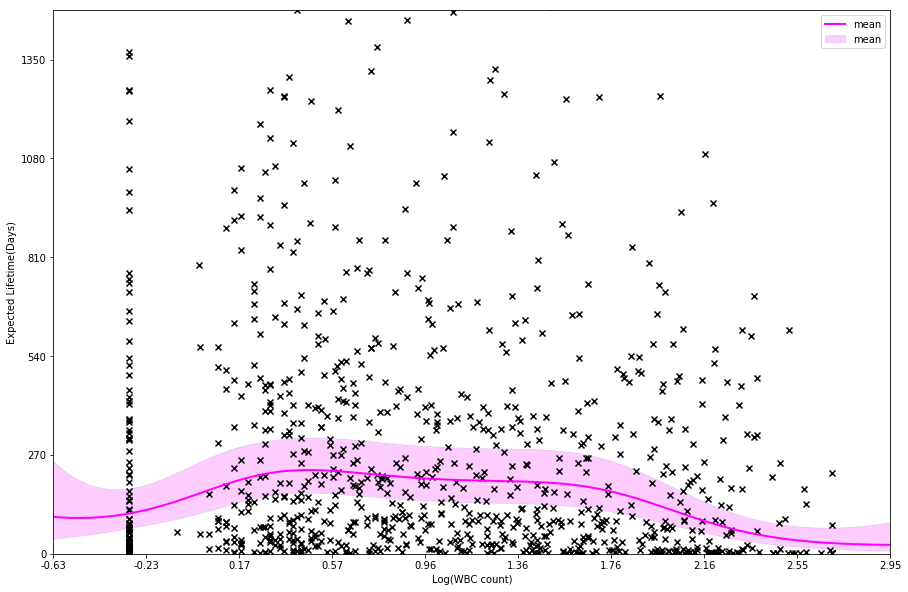

In [55]:
fig, ax2 = plt.subplots()
m_svgp1.plot_mean(fixed_inputs=[(0, np.nanmean(XF[:,0])), (1, 1), (3, np.nanmedian(XF[:,3]))], plot_raw=True, apply_link=True, color='magenta', ax=ax2, label='mean')
m_svgp1.plot_confidence(fixed_inputs=[(0, np.nanmean(XF[:,0])), (1, 1), (3, np.nanmedian(XF[:,3]))], plot_raw=True, apply_link=True, color='magenta', ax=ax2, label='mean')

y_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format( round(x*y_gmean)))
x_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format( round(x*X_std[2] + X_mean[2],2)))
ax2.yaxis.set_major_formatter(y_ticks)
ax2.xaxis.set_major_formatter(x_ticks)
m_svgp1.plot_data(visible_dims=[2], ax=ax2)

ax2.set_xlabel('Log(WBC count)')
ax2.set_ylabel('Expected Lifetime(Days)')
plt.ylim((-0,11))
plt.xlim((-2,2.5))
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)

In [36]:
m2.constrain_positive('')
m2['.*white'].constrain_bounded(1e-6,1e-2)
m2['.*bias'].constrain_bounded(1e-3,3)
m2.optimize('bfgs', max_iters=600)
print(m2)
print(m2.log_likelihood())
print(m2[''])


Name : survival3
Objective : 1687.82028146
Number of Parameters : 12
Number of Optimization Parameters : 12
Updates : True
Parameters:
  survival3.               |            value  |  constraints  |  priors
  sum.rbf.variance         |   0.231998126382  |      +ve      |        
  sum.rbf.lengthscale      |             (4,)  |      +ve      |        
  sum.bias.variance        |   0.342661165282  |   0.001,3.0   |        
  sum.white.variance       |  0.0099992680257  |  1e-06,0.01   |        
  sum.linear.variances     |             (4,)  |      +ve      |        
  Weibull.r_weibull_shape  |   0.598727662432  |      +ve      |        
-1687.82028146
  index  |         survival3.sum.rbf.variance  |  constraints  |  priors
  [0]    |                         0.23199813  |      +ve      |        
  -----  |      survival3.sum.rbf.lengthscale  |  -----------  |  ------
  [0]    |                         1.83064063  |      +ve      |        
  [1]    |                         3.59257261 

In [37]:
display(m1)
print m1['']
print m1.log_likelihood()

survival1.,value,constraints,priors
sum.rbf.variance,0.663433650571,+ve,
sum.rbf.lengthscale,"(4,)",+ve,
sum.bias.variance,0.001,"0.001,3.0",
sum.white.variance,4.46539024409e-05,"1e-06,0.01",
sum.linear.variances,"(4,)",+ve,
LogLogistic.r_log_shape,0.918494284552,+ve,


  index  |         survival1.sum.rbf.variance  |  constraints  |  priors
  [0]    |                         0.66343365  |      +ve      |        
  -----  |      survival1.sum.rbf.lengthscale  |  -----------  |  ------
  [0]    |                         1.95938136  |      +ve      |        
  [1]    |                       529.79434515  |      +ve      |        
  [2]    |                         0.50987733  |      +ve      |        
  [3]    |                         1.66298620  |      +ve      |        
  -----  |        survival1.sum.bias.variance  |  -----------  |  ------
  [0]    |                         0.00100000  |   0.001,3.0   |        
  -----  |       survival1.sum.white.variance  |  -----------  |  ------
  [0]    |                         0.00004465  |  1e-06,0.01   |        
  -----  |     survival1.sum.linear.variances  |  -----------  |  ------
  [0]    |                         1.06872816  |      +ve      |        
  [1]    |                         0.00000000  |   

In [38]:
display(m2)
print m2['']
print m2.log_likelihood()

survival3.,value,constraints,priors
sum.rbf.variance,0.231998126382,+ve,
sum.rbf.lengthscale,"(4,)",+ve,
sum.bias.variance,0.342661165282,"0.001,3.0",
sum.white.variance,0.0099992680257,"1e-06,0.01",
sum.linear.variances,"(4,)",+ve,
Weibull.r_weibull_shape,0.598727662432,+ve,


  index  |         survival3.sum.rbf.variance  |  constraints  |  priors
  [0]    |                         0.23199813  |      +ve      |        
  -----  |      survival3.sum.rbf.lengthscale  |  -----------  |  ------
  [0]    |                         1.83064063  |      +ve      |        
  [1]    |                         3.59257261  |      +ve      |        
  [2]    |                         0.36584870  |      +ve      |        
  [3]    |                         1.81517665  |      +ve      |        
  -----  |        survival3.sum.bias.variance  |  -----------  |  ------
  [0]    |                         0.34266117  |   0.001,3.0   |        
  -----  |       survival3.sum.white.variance  |  -----------  |  ------
  [0]    |                         0.00999927  |  1e-06,0.01   |        
  -----  |     survival3.sum.linear.variances  |  -----------  |  ------
  [0]    |                         0.31185713  |      +ve      |        
  [1]    |                         0.00000057  |   

We can also make predictions on a small test dataset as given below:

In [39]:
# make a small test sample dataset!!!

X_age = np.arange(15, 90, 1)
X_age = np.reshape(X_age, (-1,1))
X_median_1 = np.nanmedian(X[:,1])
X_median_2 = np.nanmedian(X[:,2])
X_test_1 = np.ones_like(X_age)*X_median_1
X_test_2 = np.ones_like(X_age)*X_median_2
X_test_0 = np.hstack((X_age, X_test_1, X_test_2))

In [40]:
# do predictions on a small sampled dataset.
quantile1 = m1.predict_quantiles(X_test)

## Plotting
We will make the plots here with different models we have. We will use the model with loglogistic likelihood for the plots as it had the highest marginal likelihood and definitely our best model here.

### Plot1 - Survival Time as a function of Age of Patient
The first plot shows how the expected median lifetime(time to event) changes according to age while keeping other covariates fixed, at their median values. We see a montonic decrease as the age of patient increases. We can also see a much larger confidence interval when the age is low, because there is higher variability.


Special Note: the expected median lifetime is equal to the latent value $f$ exponentiated. We use two flags here: "plot_raw" flag will help us to plot just the latent value $f$, and the "apply_link" flag will help us plot the inverse of the transformation we use. For example, in this case we use log-logistic likelihood which models the log of the observations as we can see that the data we are modelling can only be positive. So for log transformation, "apply_link" will plot $exp(f)$. 

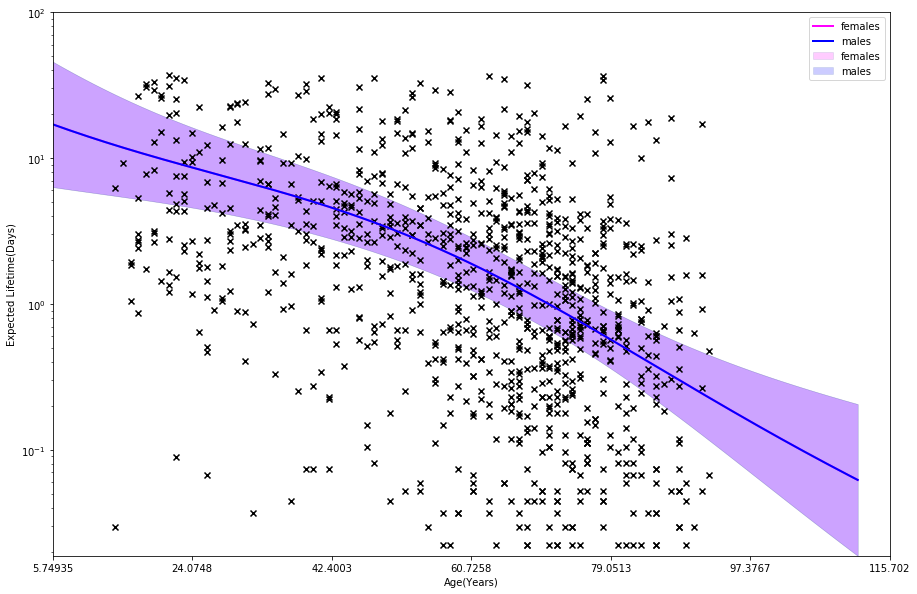

In [58]:
f, ax1 = plt.subplots()
for i in [ -1, 1]:
	if i == -1:
		c='magenta'
		label='females'
	else:
		c = 'blue'
		label='males'
	m1.plot_mean(fixed_inputs=[(1, i), (2, np.median(XF[:,2])), (3, np.median(XF[:,3]))], plot_raw=True, apply_link=True, color=c, ax=ax1, label=label)
	m1.plot_confidence(fixed_inputs=[(1, i), (2, np.median(XF[:,2])), (3, np.median(XF[:,3]))], plot_raw=True, apply_link=True, color=c, ax=ax1, label=label)
y_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*y_gmean))
x_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*X_std[0] + X_mean[0]))
# ax1.yaxis.set_major_formatter(y_ticks)
ax1.xaxis.set_major_formatter(x_ticks)
m1.plot_data(visible_dims=[0], ax=ax1)
ax1.semilogy()

ax1.set_xlabel('Age(Years)')
ax1.set_ylabel('Expected Lifetime(Days)')
plt.ylim((0,100))
plt.xlim((-3,3))
# plt.ylim((0,7))
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)
fig.savefig('plot1-loglog.png', dpi=100)
# plt.savefig('plot-agevslife.pdf')


### Plot2 - Survival Time as a function of WBC count
The first plot shows how the expected median lifetime(time to event) changes according to the log of WBC count while keeping other covariates fixed, at their median values. We can see how the expected survival time goes down to 0 as the WBC count increases, on the other extreme, it goes to the mean value where there is not so much data. As this data is taken only from Leukemia patients, we do not have WBC count for healthy patients.

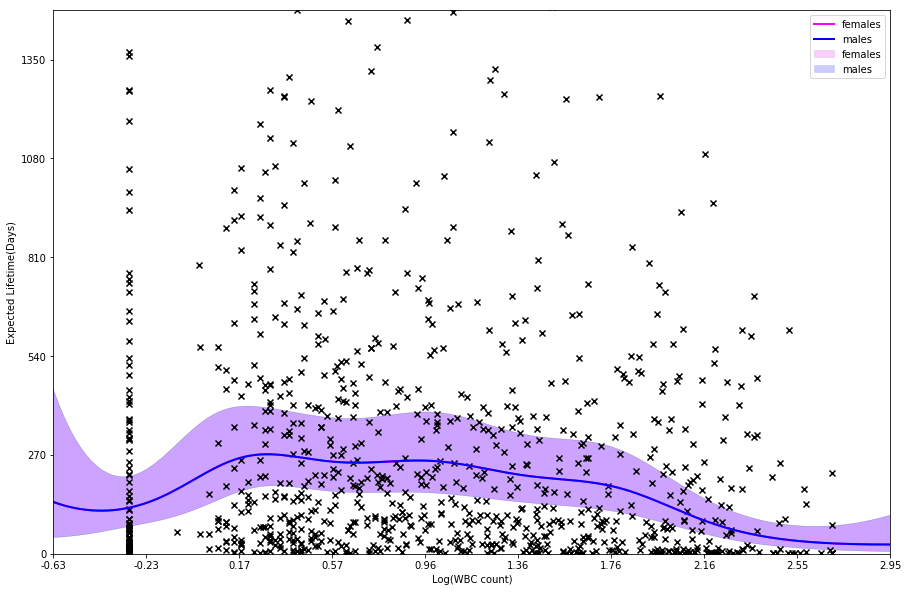

In [54]:
fig, ax2 = plt.subplots()
for i in [-1, 1]:
	if i == -1:
		c='magenta'
		label='females'
	else:
		c = 'blue'
		label='males'
	m1.plot_mean(fixed_inputs=[(0, np.nanmean(XF[:,0])), (1, i), (3, np.nanmedian(XF[:,3]))], plot_raw=True, apply_link=True, color=c, ax=ax2, label=label)
	m1.plot_confidence(fixed_inputs=[(0, np.nanmean(XF[:,0])), (1, i), (3, np.median(XF[:,3]))], plot_raw=True, apply_link=True, color=c, ax=ax2, label=label)

y_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format( round(x*y_gmean)))
x_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format( round(x*X_std[2] + X_mean[2],2)))
ax2.yaxis.set_major_formatter(y_ticks)
ax2.xaxis.set_major_formatter(x_ticks)
m1.plot_data(visible_dims=[2], ax=ax2)

ax2.set_xlabel('Log(WBC count)')
ax2.set_ylabel('Expected Lifetime(Days)')
plt.ylim((-0,11))
plt.xlim((-2,2.5))
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)
fig.savefig('plot2-loglog.png', dpi=100)


### Plot3 - Survival Time as a function of TDI Index
The first plot shows how the expected median lifetime(time to event) changes according to TDI(Townsend Deprivation Index)[3] index while keeping other covariates fixed, at their median values. It is a socio-economic indicator and measures deprivation of materials. The higher the index value, the more is deprivation of matrials. As we would expect, the survivial time goes down non linearly with increasing TDI index. 

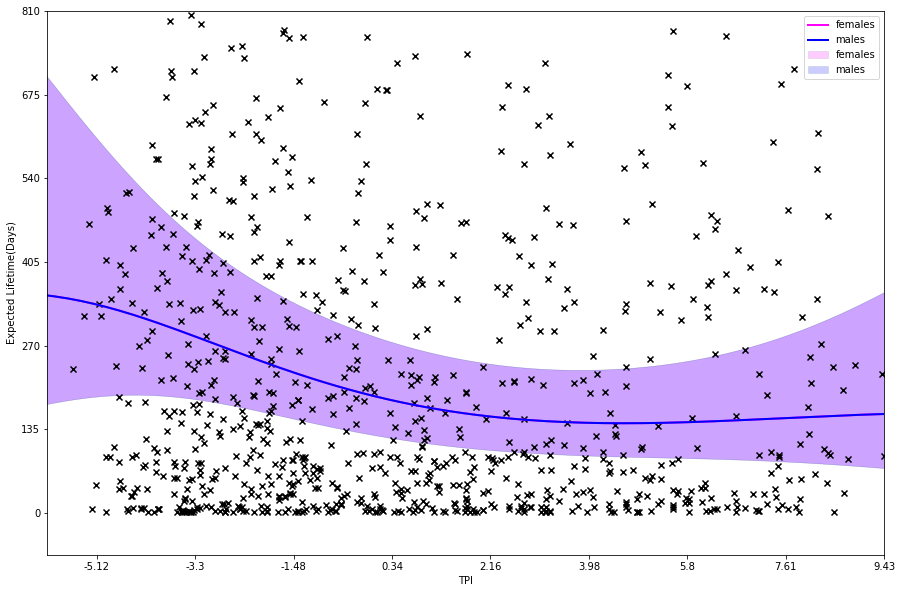

In [56]:
fig3, ax3 = plt.subplots()
for i in [-1, 1]:
    if i == -1:
        c='magenta'
        label='females'
    else:
        c = 'blue'
        label='males'
    m1.plot_mean(fixed_inputs=[(0, np.nanmedian(XF[:,0])), (1, i), (2, np.median(XF[:,2]))], plot_raw=True, apply_link=True, color=c, ax=ax3, label=label)
    m1.plot_confidence(fixed_inputs=[(0, np.nanmedian(XF[:,0])), (1, i), (2, np.median(XF[:,2]))], plot_raw=True, apply_link=True, color=c, ax=ax3, label=label)


y_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(round(x*y_gmean)))
x_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format( round(x*X_std[3] + X_mean[3],2)))
ax3.yaxis.set_major_formatter(y_ticks)
ax3.xaxis.set_major_formatter(x_ticks)
m1.plot_data(visible_dims=[3], ax=ax3)

ax3.set_xlabel('TPI')
ax3.set_ylabel('Expected Lifetime(Days)')
plt.ylim(-0.5,6)
plt.xlim(-1.75,2.5)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)
fig.savefig('plot3-loglog.png', dpi=100)


### Plot4 - Survival Time as a function of WBC count with different TDI index values for females.
This plot is an excellent example of the correlation between covariates. We plot the expected survival time of patients with two different TDI values. Higher TDI value means more deprivation. We observe how the survival time varies with log of WBC count for two different TDI  values. We see that for as WBC count goes up, survival time goes down much faster for more deprived women as compared to affluent women at the same level of WBC count.

-0.368327756494
1.5561169978


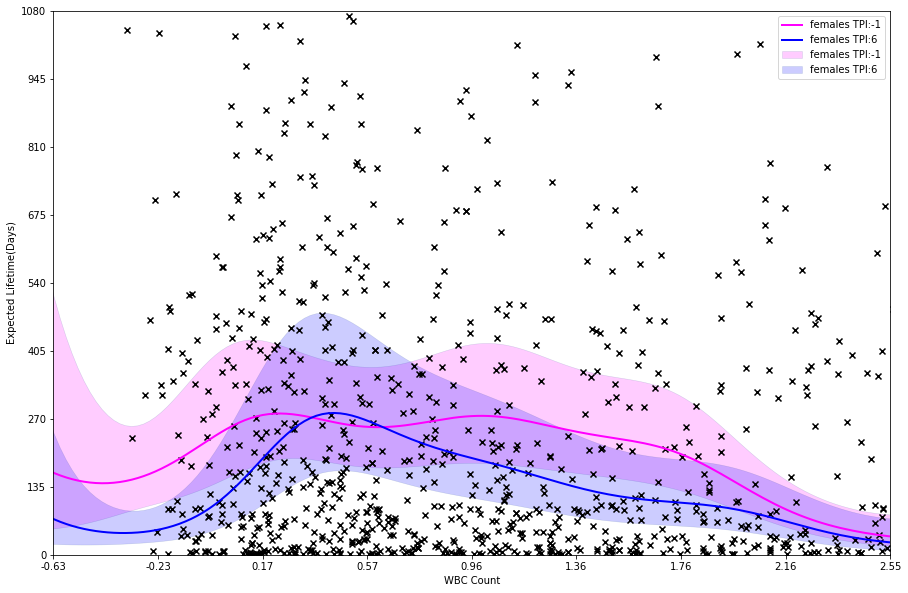

In [58]:
fig4, ax4 = plt.subplots()

tpi_test = [-1, 6]
tpi_test_norm = (tpi_test - X_mean[3]) / X_std[3]
# plot_lim1= [0,10]

for i, val in enumerate(tpi_test_norm):
    print(val)
    if i == 0:
        c='magenta'
        label='females TPI:-1'
    else:
        c = 'blue'
        label='females TPI:6'
    m1.plot_mean(fixed_inputs=[(0, np.nanmean(XF[:,0])), (1, 0), (3, val)], plot_raw=True, apply_link=True, color=c, ax=ax4, label=label)
    m1.plot_confidence(fixed_inputs=[(0, np.nanmean(XF[:,0])), (1, 0), (3, val)], plot_raw=True, apply_link=True, color=c, ax=ax4, label=label)


y_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(round(x*y_gmean)))
x_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format( round(x*X_std[2] + X_mean[2],2)))
ax4.yaxis.set_major_formatter(y_ticks)
ax4.xaxis.set_major_formatter(x_ticks)
m1.plot_data(visible_dims=[3], ax=ax4)

ax4.set_xlabel('WBC Count')
ax4.set_ylabel('Expected Lifetime(Days)')
ax4.set_ylim((0,8))
ax4.set_xlim((-2,2))
plt.legend()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)


## Optimisation and Model Selection (Soon to come in next version)
The marginal likelihood given by integrating out latent value f is given as :
$$ P(Y^{*}|X, \theta)$$ 
This serves as the objective for tuning the parameters of the covariance function and likelihood function. However for model selection and evaluation the LOO-CV could be considered as criterion for selection. LOO-CV is basically the predictive score for each data point y when considered in isolation as test point using the rest of the data for training. The  difference to marginal likelihood is that each point y is considered seperately. 
$$ P(y_{i}^{*}| X, Y_{-i}, \theta ) $$


In [59]:
print m1.log_likelihood()
print m2.log_likelihood()
# print m3.log_likelihood()

-1636.16832868
-1687.82028146


In [60]:
# loo_score1 = m1.LOO()
# print(np.sum(loo_score1))

The  LOO score for this model is almost comparable to the score given in the example of gpstuff page, infact its a bit lower than that, but we have not used CCD for hyperparameter integration, as CCD was not fully developed in GPy yet.

### Same Survival Model with loglogistic likelihood but with EP approximation

We will now do inference with EP approximation. We will make plot no.4 and compare it with the plot we got from Laplace approximation.
We notice here, that the EP does not penalise the binary-sex variable as much as Laplacian.

In [61]:
ep_alt = GPy.inference.latent_function_inference.EP(ep_mode='alternated')

In [62]:
mleuep1 = GPy.core.GP(XF, Y.copy(), kernel=kernelleu.copy(), likelihood=like_loglogistic.copy(), inference_method=ep_alt, name='survival-ep', Y_metadata=Y_metadata)

In [63]:
display(mleuep1)
print(mleuep1[''])

survival_m_ep.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,"(4,)",+ve,
sum.bias.variance,1.0,+ve,
sum.white.variance,1.0,+ve,
sum.linear.variances,"(4,)",+ve,
LogLogistic.r_log_shape,1.0,+ve,


  index  |         survival_m_ep.sum.rbf.variance  |  constraints  |  priors
  [0]    |                             1.00000000  |      +ve      |        
  -----  |      survival_m_ep.sum.rbf.lengthscale  |  -----------  |  ------
  [0]    |                             1.00000000  |      +ve      |        
  [1]    |                             1.00000000  |      +ve      |        
  [2]    |                             1.00000000  |      +ve      |        
  [3]    |                             1.00000000  |      +ve      |        
  -----  |        survival_m_ep.sum.bias.variance  |  -----------  |  ------
  [0]    |                             1.00000000  |      +ve      |        
  -----  |       survival_m_ep.sum.white.variance  |  -----------  |  ------
  [0]    |                             1.00000000  |      +ve      |        
  -----  |     survival_m_ep.sum.linear.variances  |  -----------  |  ------
  [0]    |                             1.00000000  |      +ve      |        

In [66]:
mleuep1.constrain_positive('')
mleuep1['.*white'].constrain_bounded(1e-6,1e-2)
mleuep1['.*bias'].constrain_bounded(1e-4,3)
mleuep1.optimize('bfgs', max_iters=600)
print(mleuep1.log_likelihood())
print(mleuep1[''])
# display(mleul)

-1640.43370472
  index  |         survival_m_ep.sum.rbf.variance  |  constraints  |  priors
  [0]    |                             0.69297069  |      +ve      |        
  -----  |      survival_m_ep.sum.rbf.lengthscale  |  -----------  |  ------
  [0]    |                             1.87560501  |      +ve      |        
  [1]    |                            45.68416965  |      +ve      |        
  [2]    |                             0.49338440  |      +ve      |        
  [3]    |                             1.60665646  |      +ve      |        
  -----  |        survival_m_ep.sum.bias.variance  |  -----------  |  ------
  [0]    |                             0.00010000  |  0.0001,3.0   |        
  -----  |       survival_m_ep.sum.white.variance  |  -----------  |  ------
  [0]    |                             0.00998527  |  1e-06,0.01   |        
  -----  |     survival_m_ep.sum.linear.variances  |  -----------  |  ------
  [0]    |                             1.05022174  |      +ve

### Plot 5

-0.368327756494
1.5561169978


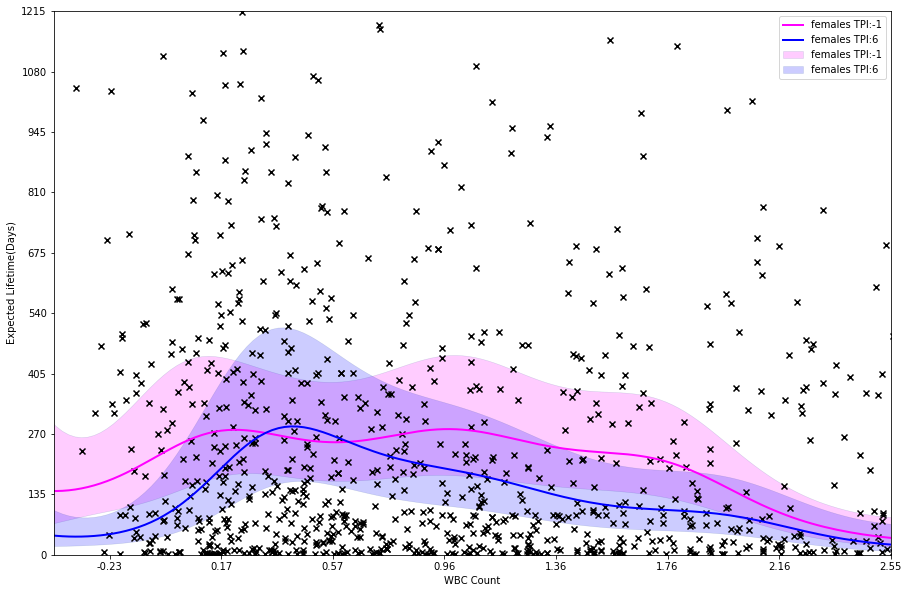

In [67]:
fig5, ax5 = plt.subplots()

tpi_test = [-1, 6]
tpi_test_norm = (tpi_test - X_mean[3]) / X_std[3]

for i, val in enumerate(tpi_test_norm):
    print(val)
    if i == 0:
        c='magenta'
        label='females TPI:-1'
    else:
        c = 'blue'
        label='females TPI:6'
    mleuep1.plot_mean(fixed_inputs=[(0, np.nanmean(XF[:,0])), (1, 0), (3, val)], plot_raw=True, apply_link=True, color=c, ax=ax5, label=label)
    mleuep1.plot_confidence(fixed_inputs=[(0, np.nanmean(XF[:,0])), (1, 0), (3, val)], plot_raw=True, apply_link=True, color=c, ax=ax5, label=label)

y_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(round(x*y_gmean)))
x_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(round(x*X_std[2] + X_mean[2],2)))
ax5.yaxis.set_major_formatter(y_ticks)
ax5.xaxis.set_major_formatter(x_ticks)

mleuep1.plot_data(visible_dims=[3], ax=ax5)
ax5.set_xlabel('WBC Count')
ax5.set_ylabel('Expected Lifetime(Days)')
ax5.set_ylim((0,9))
ax5.set_xlim((-1.75,2.0))
plt.legend()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)


###  Plot 6 - Survival Time with Age  (with EP this time)

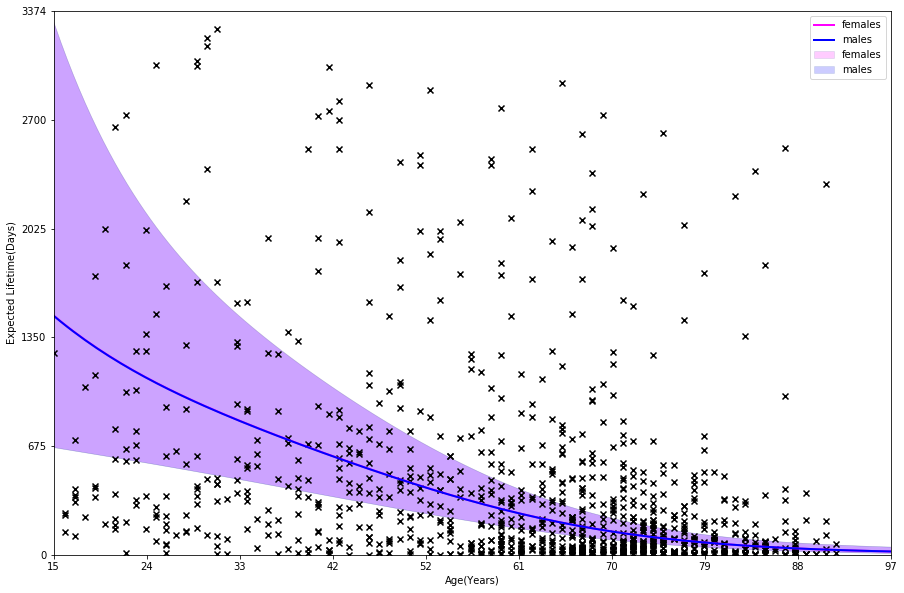

In [72]:
fig6, ax6 = plt.subplots()
for i in [ 0, 1]:
	if i == 0:
		c='magenta'
		label='females'
	else:
		c = 'blue'
		label='males'
	mleuep1.plot_mean(fixed_inputs=[(1, i), (2, np.median(XF[:,2])), (3, np.median(XF[:,3]))], plot_raw=True, apply_link=True, color=c, ax=ax6, label=label)
	mleuep1.plot_confidence(fixed_inputs=[(1, i), (2, np.median(XF[:,2])), (3, np.median(XF[:,3]))], plot_raw=True, apply_link=True, color=c, ax=ax6, label=label)
y_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(round(x*y_gmean)))
x_ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(round(x*X_std[0] + X_mean[0])))
ax6.yaxis.set_major_formatter(y_ticks)
ax6.xaxis.set_major_formatter(x_ticks)
mleuep1.plot_data(visible_dims=[0], ax=ax6)

ax6.set_xlabel('Age(Years)')
ax6.set_ylabel('Expected Lifetime(Days)')
plt.ylim((0,25))
plt.xlim((-2.5,2))
# plt.ylim((0,7))
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)
# plt.savefig('plot-agevslife.pdf')


In [73]:
# Sparse_GP1 = GPy.core.SparseGP(XF, Y.copy(), kernel=kernelleu.copy(), likelihood=like_loglogistic.copy(), Y_metadata=Y_metadata)

## References

[1] Andrew Gelman, John B. Carlin, Hal S. Stern, David B. Dunson, Aki Vehtari and Donald B. Rubin (2013). Bayesian Data Analysis, Third Edition. Chapman and Hall/CRC. 

[2] GPstuff: Bayesian Modeling with Gaussian Processes. 

[3] Peter Townsend, Townsend Deprivation Index  https://en.wikipedia.org/wiki/Townsend_deprivation_index

[4] D. Saul, Alan & Hensman, James & Vehtari, Aki & D. Lawrence, Neil. (2016). Chained Gaussian Processes. . 
    